In [1]:
spark 

In [2]:
ls

Customer churn analysis.ipynb  dockerImages/
Dockerfile                     input/
buildCluster.sh                output/
customer_segment.json          re/
data.parquet.gzip              shared_workspace/
docker-compose.yml


In [3]:
import numpy as np 
import pandas as pd
import datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import expr
from pyspark.sql.window import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.window import Window

In [4]:
for item in sorted(sc._conf.getAll()): print(item)
sqlContext = pyspark.SQLContext(sc)

('spark.app.id', 'local-1620148249432')
('spark.app.name', 'PySparkShell')
('spark.app.startTime', '1620148248697')
('spark.driver.host', '192.168.1.13')
('spark.driver.port', '52852')
('spark.executor.id', 'driver')
('spark.master', 'local[*]')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('spark.sql.catalogImplementation', 'hive')
('spark.submit.deployMode', 'client')
('spark.submit.pyFiles', '')
('spark.ui.showConsoleProgress', 'true')


In [5]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("read_file") \
                    .config("spark.driver.extraClassPath","/Users/shahin.ali/Desktop/works/spark-3.0.2-bin-hadoop3.2/jars/hadoop-common-3.2.0.jar: " \
                            "/Users/shahin.ali/Desktop/works/spark-3.0.2-bin-hadoop3.2/jars/aws-java-sdk-1.11.30.jar: " \
                            "/Users/shahin.ali/Desktop/works/spark-3.0.2-bin-hadoop3.2/jars/hadoop-aws-3.2.0.jar")\
                    .getOrCreate()
                                   
# spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", "")
# spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "")
spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
# spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-central-1.amazonaws.com")


## Read data from S3

In [6]:
df_customer_voucher = spark.read \
                           .parquet('s3a://dh-data-chef-hiring-test/data-eng/voucher-selector/data.parquet.gzip')


#### Schema 

In [7]:
df_customer_voucher.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- last_order_ts: string (nullable = true)
 |-- first_order_ts: timestamp (nullable = true)
 |-- total_orders: string (nullable = true)
 |-- voucher_amount: double (nullable = true)



In [8]:
df_customer_voucher.show()

+--------------------+------------+--------------------+-------------------+------------+--------------+
|           timestamp|country_code|       last_order_ts|     first_order_ts|total_orders|voucher_amount|
+--------------------+------------+--------------------+-------------------+------------+--------------+
|2020-05-20 15:43:...|       China|2020-04-19 00:00:...|2020-04-18 04:00:00|         0.0|        5720.0|
|2020-05-20 15:43:...|       China|2020-04-19 00:00:...|2020-04-13 04:00:00|         1.0|        8800.0|
|2020-05-20 15:36:...|       China|2020-04-19 00:00:...|2020-04-15 04:00:00|         0.0|        1760.0|
|2020-05-20 15:00:...|       China|2020-04-19 00:00:...|2020-04-13 04:00:00|            |        1760.0|
|2020-05-20 15:43:...|       China|2020-04-19 00:00:...|2020-04-14 04:00:00|         3.0|        8800.0|
|2020-05-20 15:24:...|        Peru|2020-04-19 00:00:...|2017-07-24 04:00:00|         2.0|        2640.0|
|2020-05-20 15:41:...|       China|2020-04-19 00:00:...

In [9]:
## Convert the data type for columns, which are not defined properly 
df_customer_voucher = df_customer_voucher.withColumn('event_timestamp', col('timestamp').cast('timestamp')) \
                                         .withColumn('last_order_ts', col('last_order_ts').cast('timestamp')) \
                                         .withColumn('total_orders', col('total_orders').cast('double'))

In [10]:
## fill NA/ None data for orders and voucher amount
df_customer_voucher = df_customer_voucher.fillna({'total_orders':0, 'voucher_amount':0})

In [11]:
df_customer_voucher.groupBy('country_code').agg(count('*').alias('vouchers')).show()

+------------+--------+
|country_code|vouchers|
+------------+--------+
|        Peru|  106547|
|       China|  169722|
|      Latvia|  101154|
|   Australia|  134004|
+------------+--------+



#### As requirement is for specific country, filter df for country_code : Peru

In [12]:
df_peru = df_customer_voucher.filter(col("country_code") == 'Peru')
#df_peru = df_customer_voucher

In [13]:
df_peru.count()

106547

In [14]:
# define udf
def cast_as_date(l):
  return l.cast('date')

cast_date_udf = F.udf(cast_as_date)



#### As the dataset is of historical assingment of vouchers to customers and since mentioned that timestamp is that of the event. Assuming that timestamp provided is when the voucher was provided to customer.  There seems to be event timestamp (timestamp for allocating vouchers) earlier than a customer's first_order_ts

In [15]:
#filter( '''(col("timestamp") < col("first_order_ts")) &''' (col('country_code') == 'Peru')) \

df_peru = df_peru \
                 .withColumn("days_since_last_order", F.datediff(df_peru.event_timestamp, df_peru.last_order_ts).cast('double'))
       


# df_peru.groupBy(col('event_timestamp').cast(DateType()).alias('event_timestamp'), \
#                 col('last_order_ts').cast(DateType()).alias('last_order_ts') )   \
#        .agg(count('*').alias('rec_count'), \
#             max('days_since_last_order').alias('max_days_since_last_order') ) \
#        .orderBy('event_timestamp',ascending=True) \
#        .show(500)

In [16]:
df_peru.groupBy(col('event_timestamp').cast(DateType()).alias('event_timestamp'), \
                col('last_order_ts').cast(DateType()).alias('last_order_ts'), \
                col('days_since_last_order').cast(DoubleType()).alias('days_since_last_order')  ) \
       .agg(count('*').alias('rec_count') ) \
       .orderBy('event_timestamp',ascending=True) \
       .show(500)

+---------------+-------------+---------------------+---------+
|event_timestamp|last_order_ts|days_since_last_order|rec_count|
+---------------+-------------+---------------------+---------+
|     2016-12-09|   2020-01-09|              -1126.0|       82|
|     2016-12-09|   2019-11-09|              -1065.0|       21|
|     2016-12-10|   2019-11-10|              -1065.0|       19|
|     2016-12-10|   2020-01-10|              -1126.0|       94|
|     2016-12-11|   2020-01-11|              -1126.0|       97|
|     2016-12-11|   2019-11-11|              -1065.0|       29|
|     2016-12-12|   2019-11-12|              -1065.0|       33|
|     2016-12-12|   2020-01-12|              -1126.0|       67|
|     2016-12-13|   2019-11-13|              -1065.0|       10|
|     2016-12-13|   2020-01-12|              -1125.0|       83|
|     2016-12-13|   2020-01-13|              -1126.0|       35|
|     2016-12-14|   2020-01-13|              -1125.0|       91|
|     2016-12-14|   2019-11-14|         

#### There are 8392 events, which were processed before customer placed an order on platform

In [17]:
df_peru.filter(col("event_timestamp") < col("first_order_ts") ) \
       .orderBy('event_timestamp',ascending=True) \
       .count()

8392

In [18]:
df_peru.filter(col("event_timestamp") >= col("first_order_ts") ) \
       .orderBy('event_timestamp',ascending=True) \
       .count()

98155

#### Analysing, how many events processed on monthly basis for Peru

In [19]:
## UDF convert to month ##
month_udf = udf(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%Y-%m"), returnType = StringType())


df_peru_monthly = df_peru.groupBy( month_udf( (col('event_timestamp').cast(DateType())).cast(StringType()) ).alias('YY-MM') )   \
                         .agg(count('*').alias('rec_count')) \
                         .orderBy('YY-MM',ascending=False)


#df_event_timestamps =  df_customer_voucher.groupBy( month_udf(col('timestamp').cast(DateType()).alias('timestamp')).alias('month') )   \
#                                          .agg(count('*').alias('rec_count')) \
#                                          .orderBy('month',ascending=False) \
#                                          .show()

In [20]:
months = df_peru_monthly.select('YY-MM').rdd.flatMap(lambda x: x).collect()
vals = df_peru_monthly.select('rec_count').rdd.flatMap(lambda x: x).collect()

In [21]:
list(zip(months,vals))

[('2020-05', 16915),
 ('2020-04', 40175),
 ('2020-03', 19709),
 ('2020-02', 21124),
 ('2017-03', 1415),
 ('2017-02', 3576),
 ('2017-01', 1748),
 ('2016-12', 1885)]

There are only very few events processed during 2017, 2016, so assumption is that those were either one off vouchers provided for customers initially when launching the product or might be some bug in data

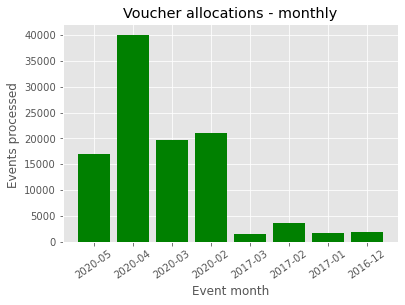

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = months
count_events = vals

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count_events, color='green')
plt.xlabel("Event month")
plt.ylabel("Events processed ")
plt.title("Voucher allocations - monthly")
plt.xticks(rotation = 35)

plt.xticks(x_pos, x)

plt.show()

In [23]:
df_peru.orderBy('days_since_last_order', ascending=False).show()

+--------------------+------------+-------------------+-------------------+------------+--------------+--------------------+---------------------+
|           timestamp|country_code|      last_order_ts|     first_order_ts|total_orders|voucher_amount|     event_timestamp|days_since_last_order|
+--------------------+------------+-------------------+-------------------+------------+--------------+--------------------+---------------------+
|2020-03-29 20:46:...|        Peru|2019-12-28 04:00:00|2019-12-28 04:00:00|         0.0|        2640.0|2020-03-30 00:46:...|                 93.0|
|2020-03-29 20:34:...|        Peru|2019-12-28 04:00:00|2018-12-06 04:00:00|        39.0|        4400.0|2020-03-30 00:34:...|                 93.0|
|2020-03-29 20:48:...|        Peru|2019-12-28 04:00:00|2019-12-27 04:00:00|        37.0|        4400.0|2020-03-30 00:48:...|                 93.0|
|2020-03-29 20:28:...|        Peru|2019-12-28 04:00:00|2019-12-27 04:00:00|         0.0|        2640.0|2020-03-30 00:2

In [24]:
# define udf
def sorter(l):
  print(l)
  l = [i for i in l if i > 0]
  res = sorted(l, reverse=True)
  res = list(set(res))
  return res

sort_udf = F.udf(sorter)


## udf for unique voucher amounts
def checklist_length(l):
    res = len(l)
    return res

checklist_length_udf = F.udf(checklist_length)

In [25]:
df_peru.groupBy('days_since_last_order'). \
        agg(   count('*').alias('count_recs'), \
               max('voucher_amount').alias('max_voucher'), \
               collect_list( col("voucher_amount")).alias('list_voucher_amounts' ) ). \
        select('days_since_last_order','max_voucher','count_recs', \
                sort_udf('list_voucher_amounts').alias('unique_voucher_amounts'), \
                checklist_length_udf(sort_udf('list_voucher_amounts')).alias('unique_voucher_amounts_len')  ). \
        orderBy('days_since_last_order', ascending=False). \
        show(1000)

+---------------------+-----------+----------+----------------------+--------------------------+
|days_since_last_order|max_voucher|count_recs|unique_voucher_amounts|unique_voucher_amounts_len|
+---------------------+-----------+----------+----------------------+--------------------------+
|                 93.0|     4400.0|      5386|  [4400.0, 2640.0, ...|                         3|
|                 92.0|     4400.0|     15302|  [4400.0, 2640.0, ...|                         3|
|                 91.0|     4400.0|      3571|  [4400.0, 2640.0, ...|                         3|
|                 90.0|     4400.0|     33532|  [4400.0, 2640.0, ...|                         3|
|                 32.0|     4400.0|      3838|  [4400.0, 2640.0, ...|                         3|
|                 31.0|     4400.0|     31859|  [4400.0, 2640.0, ...|                         3|
|                 30.0|     4400.0|      4314|  [4400.0, 2640.0, ...|                         3|
|                  6.0|     44

In [26]:
df_peru.groupBy('voucher_amount'). \
        agg(count('*').alias('count_recs'), \
            max('voucher_amount').alias('max_voucher'), \
            max('total_orders').alias('max_order')). \
        orderBy('voucher_amount', ascending=False). \
        show()

+--------------+----------+-----------+---------+
|voucher_amount|count_recs|max_voucher|max_order|
+--------------+----------+-----------+---------+
|        4400.0|     21458|     4400.0|    515.0|
|        3520.0|     22037|     3520.0|    516.0|
|        2640.0|     49102|     2640.0|    499.0|
|           0.0|     13950|        0.0|    286.0|
+--------------+----------+-----------+---------+



In [27]:
df_peru_grouped = df_peru.groupBy('voucher_amount') \
                           .agg( collect_list(col("days_since_last_order").cast('int')).alias('days_since_last_order'  ) , \
                                max('total_orders').alias('max_order'),  \
                                count('*').alias('num_orders') )
       #.withColumn("days_since_last_order", concat_ws(",", col("days_since_last_order"))) \
    
df_peru_grouped.show()

+--------------+---------------------+---------+----------+
|voucher_amount|days_since_last_order|max_order|num_orders|
+--------------+---------------------+---------+----------+
|           0.0| [31, 31, 31, 31, ...|    286.0|     13950|
|        4400.0| [-1126, 31, 31, 3...|    515.0|     21458|
|        2640.0| [31, 31, 31, 31, ...|    499.0|     49102|
|        3520.0| [31, 31, -1126, 3...|    516.0|     22037|
+--------------+---------------------+---------+----------+



In [28]:
import operator
import pyspark.sql.functions as F

# define udf
def sorter(l):
  print(l)
  res = sorted(l, reverse=True)
  return res

sort_udf = F.udf(sorter)

In [29]:
df_peru_grouped.select("voucher_amount", sort_udf("days_since_last_order"),"max_order","num_orders" ) \
  .show()

+--------------+-----------------------------+---------+----------+
|voucher_amount|sorter(days_since_last_order)|max_order|num_orders|
+--------------+-----------------------------+---------+----------+
|           0.0|         [92, 92, 92, 92, ...|    286.0|     13950|
|        4400.0|         [93, 93, 93, 93, ...|    515.0|     21458|
|        2640.0|         [93, 93, 93, 93, ...|    499.0|     49102|
|        3520.0|         [93, 93, 93, 93, ...|    516.0|     22037|
+--------------+-----------------------------+---------+----------+



In [30]:

# define udf
def cast_as_date(l):
  return l.cast('date')

cast_date_udf = F.udf(cast_as_date)

### Define customer recency_segment

In [31]:
df_peru = df_peru.selectExpr("*", \
                             "CASE WHEN days_since_last_order >= 30 AND days_since_last_order < 60 THEN '30-60' " \
                                  "WHEN days_since_last_order >= 60 AND days_since_last_order < 90 THEN '60-90' " \
                                  "WHEN days_since_last_order >= 90 AND days_since_last_order < 120 THEN '90-120' " \
                                  "WHEN days_since_last_order >= 120 AND days_since_last_order < 180 THEN '120-180' " \
                                  "WHEN days_since_last_order >= 180 THEN '180+' " \
                                  "ELSE 'Unknown' " \
                              "END AS  recency_segment")


In [32]:
df_peru.groupBy('recency_segment') \
       .agg(count('*').alias('count_recs') )  \
       .show()

+---------------+----------+
|recency_segment|count_recs|
+---------------+----------+
|        Unknown|      8745|
|         90-120|     57791|
|          30-60|     40011|
+---------------+----------+



In [33]:
# from pyspark.sql.window import Window
# windowSpec = Window.partitionBy("recency_segment").orderBy("rec_counts")

In [34]:
cols = ["recency_segment", "rec_counts"]

windowSpec = Window.partitionBy("recency_segment").orderBy(col("rec_counts").desc()) 

df_peru_recency = df_peru.groupBy('recency_segment', 'voucher_amount') \
                         .agg(count('*').alias('rec_counts')) \
                         .select('recency_segment','voucher_amount','rec_counts' )  \
                         .select('*' ,F.row_number().over(windowSpec ).alias('rownum_recency_segment') )  \
                         .orderBy(*cols, ascending=False )

In [35]:
df_peru_recency.show()

+---------------+--------------+----------+----------------------+
|recency_segment|voucher_amount|rec_counts|rownum_recency_segment|
+---------------+--------------+----------+----------------------+
|        Unknown|        2640.0|      4088|                     1|
|        Unknown|        3520.0|      1801|                     2|
|        Unknown|        4400.0|      1780|                     3|
|        Unknown|           0.0|      1076|                     4|
|         90-120|        2640.0|     22854|                     1|
|         90-120|        3520.0|     12243|                     2|
|         90-120|        4400.0|     11869|                     3|
|         90-120|           0.0|     10825|                     4|
|          30-60|        2640.0|     22160|                     1|
|          30-60|        3520.0|      7993|                     2|
|          30-60|        4400.0|      7809|                     3|
|          30-60|           0.0|      2049|                   

In [36]:
df_peru_recency = df_peru_recency.filter(col("rownum_recency_segment") == 1)
df_peru_recency.show()

+---------------+--------------+----------+----------------------+
|recency_segment|voucher_amount|rec_counts|rownum_recency_segment|
+---------------+--------------+----------+----------------------+
|        Unknown|        2640.0|      4088|                     1|
|         90-120|        2640.0|     22854|                     1|
|          30-60|        2640.0|     22160|                     1|
+---------------+--------------+----------+----------------------+



### Define customer frequent_segment

In [37]:
df_peru = df_peru.selectExpr("*", \
                        "CASE WHEN total_orders >= 0 AND total_orders <= 4 THEN '0-4' " \
                             "WHEN total_orders >= 5 AND total_orders <= 13 THEN '5-13' " \
                             "WHEN total_orders > 13 AND total_orders <= 37 THEN '13-37' " \
                             "ELSE 'Unknown' " \
                         "END AS  frequent_segment")

In [38]:
df_peru.groupBy('frequent_segment') \
       .agg(count('*').alias('count_recs') )  \
       .show()

+----------------+----------+
|frequent_segment|count_recs|
+----------------+----------+
|           13-37|     21930|
|         Unknown|     41407|
|            5-13|      7011|
|             0-4|     36199|
+----------------+----------+



In [39]:
cols = ["frequent_segment", "rec_counts"]

windowSpec = Window.partitionBy("frequent_segment").orderBy(col("rec_counts").desc()) 

df_peru_frequent = df_peru.groupBy('frequent_segment', 'voucher_amount') \
                         .agg(count('*').alias('rec_counts')) \
                         .select('frequent_segment','voucher_amount','rec_counts' )  \
                         .select('*' ,F.row_number().over(windowSpec ).alias('rownum_frequent_segment') )  \
                         .orderBy(*cols, ascending=False )

In [40]:
df_peru_frequent.show()

+----------------+--------------+----------+-----------------------+
|frequent_segment|voucher_amount|rec_counts|rownum_frequent_segment|
+----------------+--------------+----------+-----------------------+
|         Unknown|        2640.0|     16681|                      1|
|         Unknown|        4400.0|      8559|                      2|
|         Unknown|        3520.0|      8514|                      3|
|         Unknown|           0.0|      7653|                      4|
|            5-13|        2640.0|      4112|                      1|
|            5-13|        3520.0|      1374|                      2|
|            5-13|        4400.0|      1272|                      3|
|            5-13|           0.0|       253|                      4|
|           13-37|        2640.0|     11813|                      1|
|           13-37|        3520.0|      4391|                      2|
|           13-37|        4400.0|      4225|                      3|
|           13-37|           0.0| 

In [41]:
df_peru_frequent = df_peru_frequent.filter(col("rownum_frequent_segment") == 1)
df_peru_frequent.show()

+----------------+--------------+----------+-----------------------+
|frequent_segment|voucher_amount|rec_counts|rownum_frequent_segment|
+----------------+--------------+----------+-----------------------+
|         Unknown|        2640.0|     16681|                      1|
|            5-13|        2640.0|      4112|                      1|
|           13-37|        2640.0|     11813|                      1|
|             0-4|        2640.0|     16496|                      1|
+----------------+--------------+----------+-----------------------+



#### Generated two customer segments, fetch the most number of vouchers provided for given segment. As per pipeline, two dataframes has been generated

In [42]:
import json
results_frequent_segment = df_peru_frequent.toJSON().map(lambda j: json.loads(j)).collect()
results_recency_segment = df_peru_recency.toJSON().map(lambda j: json.loads(j)).collect()

In [43]:
results_frequent_segment

[{'frequent_segment': 'Unknown',
  'voucher_amount': 2640.0,
  'rec_counts': 16681,
  'rownum_frequent_segment': 1},
 {'frequent_segment': '5-13',
  'voucher_amount': 2640.0,
  'rec_counts': 4112,
  'rownum_frequent_segment': 1},
 {'frequent_segment': '13-37',
  'voucher_amount': 2640.0,
  'rec_counts': 11813,
  'rownum_frequent_segment': 1},
 {'frequent_segment': '0-4',
  'voucher_amount': 2640.0,
  'rec_counts': 16496,
  'rownum_frequent_segment': 1}]

In [44]:
results_recency_segment

[{'recency_segment': 'Unknown',
  'voucher_amount': 2640.0,
  'rec_counts': 4088,
  'rownum_recency_segment': 1},
 {'recency_segment': '90-120',
  'voucher_amount': 2640.0,
  'rec_counts': 22854,
  'rownum_recency_segment': 1},
 {'recency_segment': '30-60',
  'voucher_amount': 2640.0,
  'rec_counts': 22160,
  'rownum_recency_segment': 1}]

In [45]:
customer_segment = {}
customer_segment['frequent_segment'] = {}
customer_segment['recency_segment'] = {}


for r in results_frequent_segment:
    customer_segment['frequent_segment'][r.get('frequent_segment')] = r.get('voucher_amount')
for r in results_recency_segment:
    customer_segment['recency_segment'][r.get('recency_segment')] = r.get('voucher_amount')

In [46]:
customer_segment

{'frequent_segment': {'Unknown': 2640.0,
  '5-13': 2640.0,
  '13-37': 2640.0,
  '0-4': 2640.0},
 'recency_segment': {'Unknown': 2640.0, '90-120': 2640.0, '30-60': 2640.0}}

In [47]:
with open('customer_segment.json', 'w') as fp:
    json.dump(customer_segment, fp)